<a href="https://colab.research.google.com/github/hnymz/HSSM/blob/main/HSSM_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yiming to do

- Get on Slack and text me (check in with An Vo how to do this)
- Create a Github repo in which we will further develop this tutorial
- Familiarize yourself with looking up HSSM functions and tutorials here: https://lnccbrown.github.io/HSSM/api/hssm/
- Investigate how to save and load models. Some code provided below. But make sure that when you load you have all the needed info!
- Create parametery recovery plots for 4 different n_subjects and 4 different n_trials (Check the 2013 HDDM paper in Frontiers). Compare the group-level parameters between ground truth and fitted values. Also correlate per-subject level parameters. You can create a larger dataset and then subset per subject or trial number. You can fit&save models in a loop and then plot parametery recovery.  

Low priority (only if all the above is done)
- Install HSSM on Oscar following: https://github.com/lnccbrown/HSSM/discussions/440
- Get familiar with using VS code on Oscar (check Interactive Sessions/Code Server)
- Run a simple model in a batch job (reach out to Ivan for scripts)
- Do all of the above for the angle model
- trytry

## Updates:

- Github page: https://github.com/hnymz/HSSM
- Save and load models: No bug found. Models were saved in a list and I can access all information of models (e.g., diagnostics, posterior samples, plots) even without loading them.
- Parameter recovery plots: In the line plots, mean absolute error was used according to Wiecki et al. (2013). For each subject, each chain, and each draw, absolute error was calculated using: abs(fitted value - ground truth). All absolute errors were added up and then devided by (n_chains * n_draws * n_subjects). The influence of numbers of subjects seems to be smaller than numbers of trials.
 - Changing the runtime type to GPU can speed up the process a lot.
 - I have tried to convert the sampling process into a self-defined function. It worked, but the sampling was extremely slow, so no function was used in the current sampling version.
 - To magnify the influence of the number of trials (subjects), the number of subjects (trials) was set to be relatively low (subjects = 20, trials = 40).
- HSSM: I have managed to set up HSSM on Oscar. [PS: There seem to be two typos (maybe) in the tutorial: module load intel-one-mkl. "intel-one-mkl" should be "intel-oneapi-mkl". "intel-one-mkl" is not an existing module on Oscar.]
- VS code: I am setting it up.

# Install packages

In [ ]:
!pip install numpy==1.23.4
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.4 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.4 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.4 which is incompatible.


  Cloning https://github.com/lnccbrown/hssm (to revision main) to /tmp/pip-req-build-3fa20q0o
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/hssm /tmp/pip-req-build-3fa20q0o
  Resolved https://github.com/lnccbrown/hssm to commit c1a7ae99b25c956e4ac73502af4ee9a01be738b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.9/764.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 38.9 MB

# Import packages

In [ ]:
import hssm
import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

# Generate data

In [ ]:
n_subjects = 40  # number of subjects
n_trials = 100  # number of trials per subject - vary from low to high values to check shrinkage
sd_v = 0.3  # sd for v-intercept
sd_a = 0.3  # sd for v-intercept
mean_v = 1.25  # mean for v-intercept
mean_vx = 0.8 # mean for slope of x onto v
mean_vy = 0.2 # mean for slope of x onto v

sd_t=0.1
sd_z=0.1
mean_a = 1.5
mean_t = 0.5
mean_z = 0.5
data_list = []
param_list =[]
for i in range(n_subjects):
    # Make parameters for subject i
    intercept = np.random.normal(mean_v, sd_v, size=1)
    x = np.random.uniform(-1, 1, size=n_trials)
    y = np.random.uniform(-1, 1, size=n_trials)
    v_x = np.random.normal(mean_vx, sd_v, size=1)
    v_y = np.random.normal(mean_vy, sd_v, size=1)
    v = intercept + (v_x * x) + (v_y * y)
    a = np.random.normal(mean_a, sd_a, size=1)
    z = np.random.normal(mean_z, sd_z, size=1)
    t = np.random.normal(mean_t, sd_t, size=1)

# v is a vector which differs over trials by x and y, so we have different v for every trial - other params are same for all trials
    true_values = np.column_stack(
     [v, np.repeat(a, axis=0, repeats=n_trials), np.repeat(z, axis=0, repeats=n_trials), np.repeat(t, axis=0, repeats=n_trials)]
)
    # Simulate data
    obs_ddm_reg_v = hssm.simulate_data(model="ddm", theta=true_values, size=1)
   # store ground truth params
    param_list.append(
       pd.DataFrame(
           {
               "v_Intercept": intercept,
               "v_x": v_x,
               "v_y": v_y,
               "a": a,
               "z": z,
               "t": t,
               "subject": i
            }
       )
       )
    # Append simulated data to list
    data_list.append(
        pd.DataFrame(
            {
                "rt": obs_ddm_reg_v["rt"],
                "response": obs_ddm_reg_v["response"],
                "x": x,
                "y": y,
                "subject": i,
            }
        )
    )
# Make single dataframe out of subject-wise datasets
dataset_reg_v_hier_full = pd.concat(data_list)
dataset_reg_v_hier_full

rt  response         x         y  subject
0   0.478744       1.0  0.425850 -0.907675        0
1   0.518221       1.0  0.084406 -0.826346        0
2   0.959814       1.0 -0.044628  0.532134        0
3   1.027421       1.0 -0.926514 -0.928871        0
4   1.152706       1.0 -0.072979  0.224390        0
..       ...       ...       ...       ...      ...
95  0.827688       1.0 -0.553791  0.123780       39
96  0.899366       1.0  0.364730 -0.508389       39
97  2.723126      -1.0 -0.486890 -0.983622       39
98  1.369145       1.0  0.401115 -0.871975       39
99  2.938543      -1.0 -0.702406  0.969659       39

[4000 rows x 5 columns]

# Model specification

In [ ]:
model_reg_v_ddm_hier1A = hssm.HSSM(
    data=dataset_reg_v_hier_full,
    model="ddm",
    loglik_kind="analytical",  # approx_differentiable = LAN likelihood; analytical = Navarro & Fuss
    prior_settings="safe",
    p_outlier=0, # remove the p_outlier for now due to a current bug in HSSM
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + x + y + (1 + x + y | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 1, "sigma": 2, "initval": 1},
                "x": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "y": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.5},
                "x|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5},
                "y|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5}
            },
            "link": "identity",
        },
        {
            "name": "t",
            "formula": "t ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.5, "sigma": 0.4, "initval": 0.3},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.1}
            },
            "link": "identity",
        },
        {
            "name": "z",
            "formula": "z ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "HalfNormal", "sigma": 1, "initval": 0.5},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.05}, "initval": 0.01}
            },
        },
        {
            "name": "a",
            "formula": "a ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Gamma", "mu": 0.5, "sigma": 1.75, "initval": 1},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.3}
            },
        },
    ]
)

# print the model
model_reg_v_ddm_hier1A

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4000

Parameters:

v:
    Formula: v ~ 1 + x + y + (1 + x + y | subject)
    Priors:
        v_Intercept ~ Normal(mu: 1.0, sigma: 2.0, initval: 1.0)
        v_x ~ Normal(mu: 0.0, sigma: 1.0, initval: 0.0)
        v_y ~ Normal(mu: 0.0, sigma: 1.0, initval: 0.0)
        v_1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0), initval: 0.5)
        v_x|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5), initval: 0.5)
        v_y|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5), initval: 0.5)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1 | subject)
    Priors:
        a_Intercept ~ Gamma(mu: 0.5, sigma: 1.75, initval: 1.0)
        a_1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0), initval: 0.3)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1 | subject)
    Priors:
        z_Intercept

# Sampling

In [ ]:
samples_model_reg_v_ddm_hier1A = model_reg_v_ddm_hier1A.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=3,  # how many chains to run
    draws=200,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 400/400 [01:20<00:00,  5.00it/s, 63 steps of size 1.05e-01. acc. prob=0.89]
ERROR:pymc.stats.convergence:There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Check the posterior

## Summary

In [ ]:
az.summary(samples_model_reg_v_ddm_hier1A, var_names=["v_Intercept", "v_x", "v_y", "v_1|subject_sigma", "v_x|subject_sigma","v_y|subject_sigma", "a_1|subject_sigma", "a_Intercept", "t_Intercept", "z_Intercept", "t_1|subject_sigma", "z_1|subject_sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
v_Intercept        1.423  0.058   1.318    1.525      0.003    0.002   
v_x                0.785  0.058   0.668    0.893      0.002    0.002   
v_y                0.180  0.060   0.071    0.293      0.004    0.003   
v_1|subject_sigma  0.310  0.045   0.222    0.389      0.003    0.002   
v_x|subject_sigma  0.303  0.054   0.212    0.407      0.004    0.003   
v_y|subject_sigma  0.329  0.049   0.249    0.421      0.002    0.002   
a_1|subject_sigma  0.281  0.040   0.215    0.359      0.002    0.001   
a_Intercept        1.600  0.050   1.499    1.687      0.003    0.002   
t_Intercept        0.517  0.022   0.479    0.562      0.001    0.001   
z_Intercept        0.448  0.017   0.413    0.478      0.001    0.001   
t_1|subject_sigma  0.123  0.017   0.088    0.154      0.001    0.001   
z_1|subject_sigma  0.087  0.013   0.064    0.110      0.001    0.000   

                   ess_bulk  ess_tail  r_hat  
v_Intercept           308.0     288.0   1.01  
v_x                   566.0     489.0   1.01  
v_y                   282.0     449.0   1.01  
v_1|subject_sigma     304.0     295.0   1.01  
v_x|subject_sigma     220.0     390.0   1.00  
v_y|subject_sigma     401.0     478.0   1.00  
a_1|subject_sigma     486.0     473.0   1.00  
a_Intercept           316.0     376.0   1.00  
t_Intercept           361.0     368.0   1.02  
z_Intercept           288.0     287.0   1.00  
t_1|subject_sigma     334.0     454.0   1.01  
z_1|subject_sigma     329.0     377.0   1.00

## Plots

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (16) is smaller than the number of variables to plot (22), generating only 16 plots
  warnings.warn(


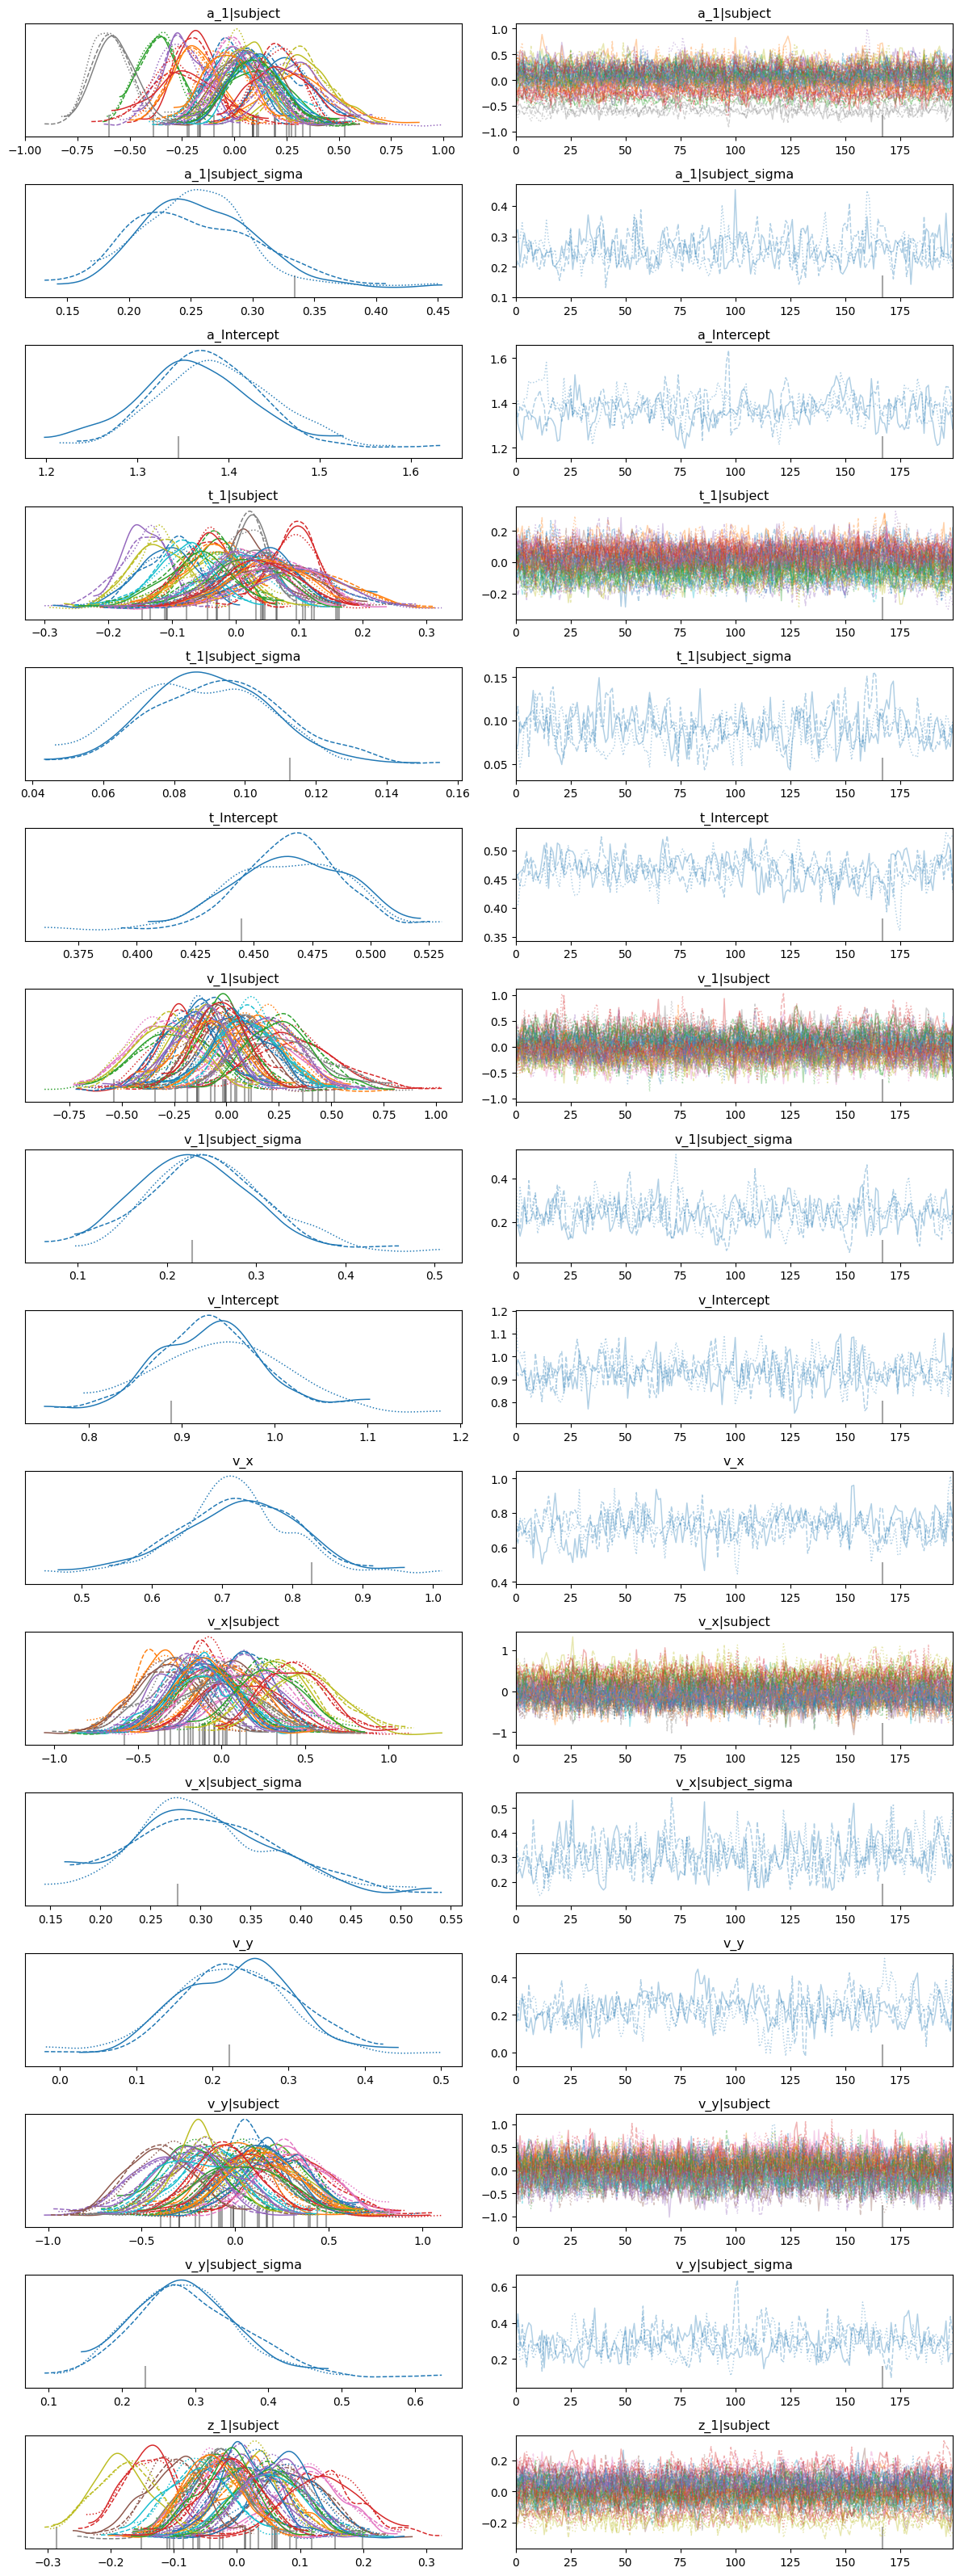

In [ ]:
az.rcParams["plot.max_subplots"] = 32
az.plot_trace(samples_model_reg_v_ddm_hier1A)
plt.tight_layout()
plt.show()

# Save & load the model (debug)

In [ ]:
# Save
samples_model_reg_v_ddm_hier1A.to_netcdf('modelTraces')

# Load
modelObject = az.InferenceData.from_netcdf('modelTraces')

# Re-attach
samples_model_reg_v_ddm_hier1A._inference_obj = modelObject

In [ ]:
samples_model_reg_v_ddm_hier1A

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Parameter recovery

In [ ]:
n_batch = 4 # how many different numbers of subjects/trials
n_subjects = 20 # how many subjects when number of trials is fixed
n_trials = 40 # how many trials when number of subjects is fixed
min_subject = 10 # minimum number of subjects
step_subject = 10 # the difference between each number of subjects
min_trial = 40
step_trial = 20
subject_con = False # when Ture, number of subjects is changing
trial_con = not subject_con
error_list = {'n_subjects': [], 'n_trials': []}
models = []
np.random.seed(123)

for batch in range(n_batch):
    if subject_con:
        n_subjects = min_subject + step_subject * batch # calculate numbers of subjects for each level
    if trial_con:
        n_trials = min_trial + step_trial * batch

    # subset of dataset: only choose the first n_trials rows of each subject
    dataset_reg_v_hier = dataset_reg_v_hier_full[dataset_reg_v_hier_full['subject'].isin(range(n_subjects))]
    dataset_reg_v_hier = dataset_reg_v_hier.groupby('subject').head(n_trials)

    error_list['n_subjects'].append(n_subjects)
    error_list['n_trials'].append(n_trials)

    model_reg_v_ddm_hier1A = hssm.HSSM(
        data=dataset_reg_v_hier,
        model="ddm",
        loglik_kind="analytical",  # approx_differentiable = LAN likelihood; analytical = Navarro & Fuss
        prior_settings="safe",
        p_outlier=0, # remove the p_outlier for now due to a current bug in HSSM
        include=[
            {
                "name": "v",
                "formula": "v ~ 1 + x + y + (1 + x + y | subject)",
                "prior": {
                    "Intercept": {"name": "Normal", "mu": 1, "sigma": 2, "initval": 1},
                    "x": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                    "y": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                    "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.5},
                    "x|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5},
                    "y|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5}
                },
                "link": "identity",
            },
            {
                "name": "t",
                "formula": "t ~ 1 + (1 | subject)",
                "prior": {
                    "Intercept": {"name": "Normal", "mu": 0.5, "sigma": 0.4, "initval": 0.3},
                    "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.1}
                },
                "link": "identity",
            },
            {
                "name": "z",
                "formula": "z ~ 1 + (1 | subject)",
                "prior": {
                    "Intercept": {"name": "HalfNormal", "sigma": 1, "initval": 0.5},
                    "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.05}, "initval": 0.01}
                },
            },
            {
                "name": "a",
                "formula": "a ~ 1 + (1 | subject)",
                "prior": {
                    "Intercept": {"name": "Gamma", "mu": 0.5, "sigma": 1.75, "initval": 1},
                    "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.3}
                },
            },
        ]
    )

    print(f"Model fitting! using {n_trials} trials and {n_subjects} subjects")
    samples_model_reg_v_ddm_hier1A = model_reg_v_ddm_hier1A.sample(
        sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
        cores=1,  # how many cores to use
        chains=3,  # how many chains to run
        draws=200,  # number of draws from the markov chain
        tune=200,  # number of burn-in samples
        idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    )

    models.append(samples_model_reg_v_ddm_hier1A)
    samples_model_reg_v_ddm_hier1A.to_netcdf(f'modelTraces_{batch}.nc')


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Model fitting! using 40 trials and 20 subjects


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 400/400 [00:49<00:00,  8.10it/s, 63 steps of size 7.44e-02. acc. prob=0.96]
ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Model fitting! using 60 trials and 20 subjects


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s, 63 steps of size 8.15e-02. acc. prob=0.92]
ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Model fitting! using 80 trials and 20 subjects


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 400/400 [01:13<00:00,  5.48it/s, 63 steps of size 8.01e-02. acc. prob=0.93]
ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Model fitting! using 100 trials and 20 subjects


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s, 63 steps of size 7.77e-02. acc. prob=0.92]
ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
def post_estimate(param):
    """Calculate the absolute error between ground truth and fitted value."""
    if param == 'v_Intercept':
        param_subject = posterior['v_1|subject'][chain, draw, subject].values.item() # subject-level intercept
    elif param == 'v_x':
        param_subject = posterior['v_x|subject'][chain, draw, subject].values.item() # subject-level slope
    elif param == 'v_y':
        param_subject = posterior['v_y|subject'][chain, draw, subject].values.item() # subject-level slope

    if param in ['a', 'z', 't']:
        fitted_value = posterior[param][chain, draw, subject * n_trials].values.item()
    else:
        param_group = posterior[param][chain, draw].values.item() # group-level slope/intercept
        fitted_value = param_subject + param_group # fitted value = group + subject

    truth = param_list[subject][param] # ground truth

    abs_error = abs(fitted_value - truth)[0] # absolute error

    return abs_error

In [ ]:
param_test = ['a', 'z', 't', 'v_Intercept', 'v_x', 'v_y'] # parameters of interest
error_list.update({key: [] for key in param_test})

for batch in range(n_batch):
    posterior = models[batch]['posterior']  # extract the posterior samples for each model
    shape = posterior["a"].shape  # num_chains * num_draws * num_trials
    error = [0 for i in range(len(param_test))]
    n_subjects = error_list['n_subjects'][batch]
    n_trials = error_list['n_trials'][batch]

    for subject in range(n_subjects):
        for chain in range(shape[0]):
            for draw in range(shape[1]):
                for i in range(len(param_test)):
                    error[i] += post_estimate(param=param_test[i])

    error = [i / (shape[0] * shape[1] * n_subjects) for i in error] # average across chains, draws, and subjects

    for i, key in enumerate(param_test):
        error_list[key].append(error[i])
        posterior[key]

error_df = pd.DataFrame(error_list)
error_df

n_subjects  n_trials         a         z         t  v_Intercept       v_x  \
0          20        40  0.178375  0.080414  0.065552     0.206225  0.280229   
1          20        60  0.166247  0.072403  0.057883     0.186111  0.217909   
2          20        80  0.150589  0.066233  0.053566     0.186241  0.187064   
3          20       100  0.141141  0.055202  0.050278     0.174152  0.178257   

        v_y  
0  0.253733  
1  0.202061  
2  0.182179  
3  0.167022

# Plots

## Line plots

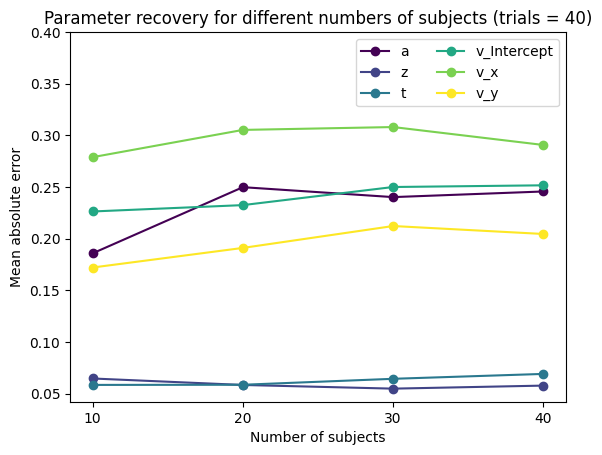

In [ ]:
# Plot parameter recovery for different numbers of subjects (trials = 40)
x_values = [10, 20, 30, 40]
cmap = plt.get_cmap('viridis') # color map
for i in range(len(param_test)):
    plt.plot(x_values, error_df[param_test[i]], color=cmap(i / (len(param_test) - 1)), marker='o', label=param_test[i])

plt.xticks(x_values)
current_ylim = plt.gca().get_ylim()
plt.ylim(current_ylim[0], 0.4) # adjust the range of y-axis if necessary
plt.xlabel('Number of subjects')
plt.ylabel('Mean absolute error')
plt.title('Parameter recovery for different numbers of subjects (trials = 40)')
plt.legend(loc='upper right', ncol=2)
plt.show()

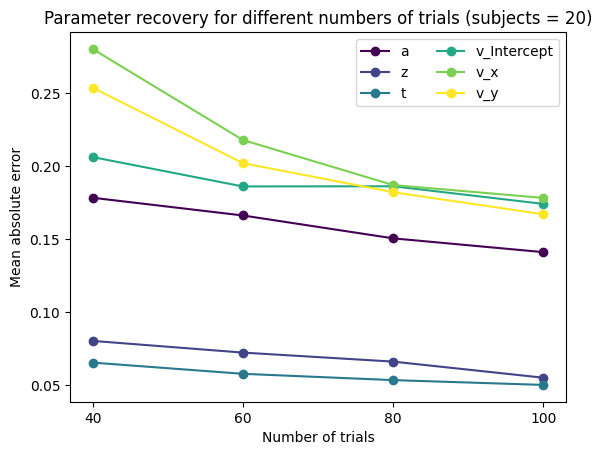

In [ ]:
# Plot parameter recovery for different numbers of subjects (subjects = 20)
x_values = error_df['n_trials']
cmap = plt.get_cmap('viridis') # color map
for i in range(len(param_test)):
    plt.plot(x_values, error_df[param_test[i]], color=cmap(i / (len(param_test) - 1)), marker='o', label=param_test[i])

plt.xticks(x_values)
current_ylim = plt.gca().get_ylim()
#plt.ylim(current_ylim[0], 0.4) # adjust the range of y-axis if necessary
plt.xlabel('Number of trials')
plt.ylabel('Mean absolute error')
plt.title('Parameter recovery for different numbers of trials (subjects = 20)')
plt.legend(loc='upper right', ncol=2)
plt.show()

## Correlation plots

### Different numbers of subjects

In [ ]:
param_df = pd.concat(param_list)

def post_fitted(sub, grp):
    """Calculate the averaged (across chains and draws) fitted value for each subject."""
    fitted_list = []
    for batch in range(n_batch):
        tem = []
        posterior = models[batch]['posterior']  # extract poterior samples for each model
        n_subjects = error_list['n_subjects'][batch]
        n_trials = error_list['n_trials'][batch]

        for subject in range(n_subjects):
            sub_param = np.sum(posterior[sub], axis=(0, 1))[subject].values.item() # subject-level
            grp_param = np.sum(posterior[grp]).values.item()                       # group-level
            fitted_param = (sub_param + grp_param) / (shape[0] * shape[1])         # average across chains and draws
            tem.append(fitted_param)

        fitted_list.append(tem)

    return fitted_list

In [ ]:
def corre_plot(param):
    """Plot correlation and R2 for ground truth and fitted values."""

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        n_subjects = error_list['n_subjects'][i]
        n_trials = error_list['n_trials'][i]
        truth = param_df[param].head(n_subjects) # ground truth
        post = fitted_list[i]                    # fitted values

        # Perform linear regression to get the slope and intercept
        slope, intercept = np.polyfit(truth, post, 1)

        # Calculate the predicted values using the regression line
        predicted_values = np.array(truth) * slope + intercept

        # Calculate R-squared
        r_squared = r2_score(post, predicted_values)

        ax.scatter(truth, post)
        ax.plot(truth, predicted_values, color='red', label=f'R² = {r_squared:.2f}')

        ax.set_xlabel(f'{param} - ground truth')
        ax.set_ylabel(f'{param} - posterior mean')
        ax.set_title(f'{n_subjects} subjects and {n_trials} trials')
        ax.legend(loc='upper left')

    plt.suptitle(f'Prameter recovery results for {param} for different numbers of trials', fontsize=15)
    plt.tight_layout()
    plt.show()

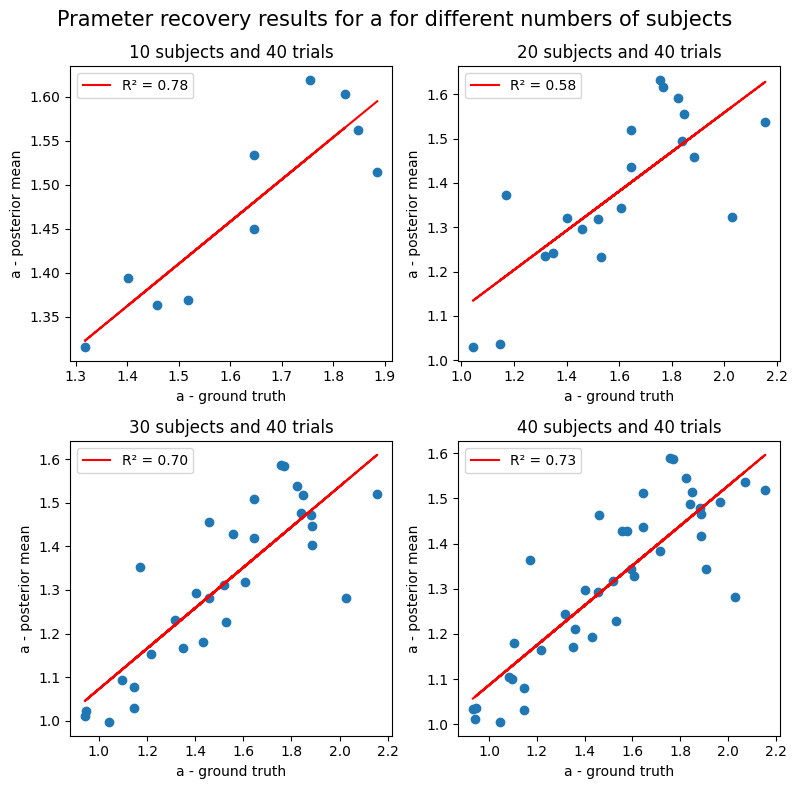

In [ ]:
fitted_list = post_fitted(sub='a_1|subject', grp='a_Intercept')
corre_plot(param='a')

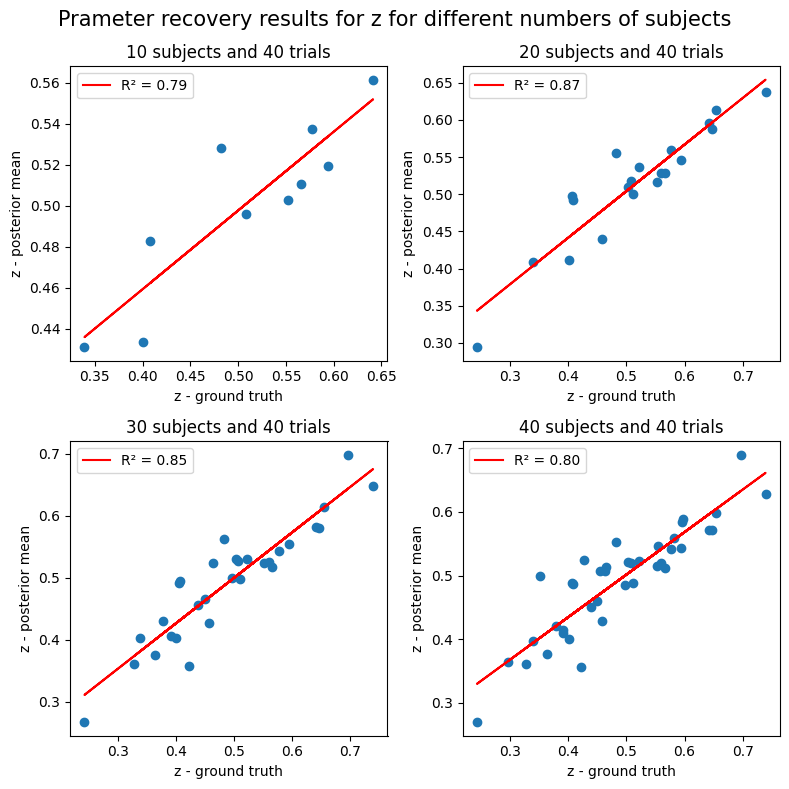

In [ ]:
fitted_list = post_fitted(sub='z_1|subject', grp='z_Intercept')
corre_plot(param='z')

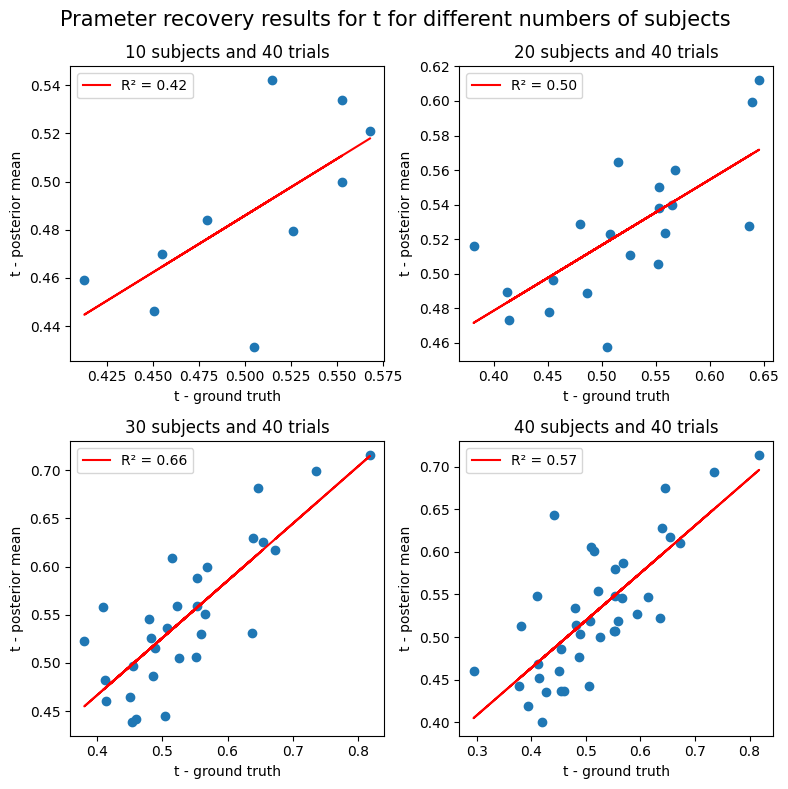

In [ ]:
fitted_list = post_fitted(sub='t_1|subject', grp='t_Intercept')
corre_plot(param='t')

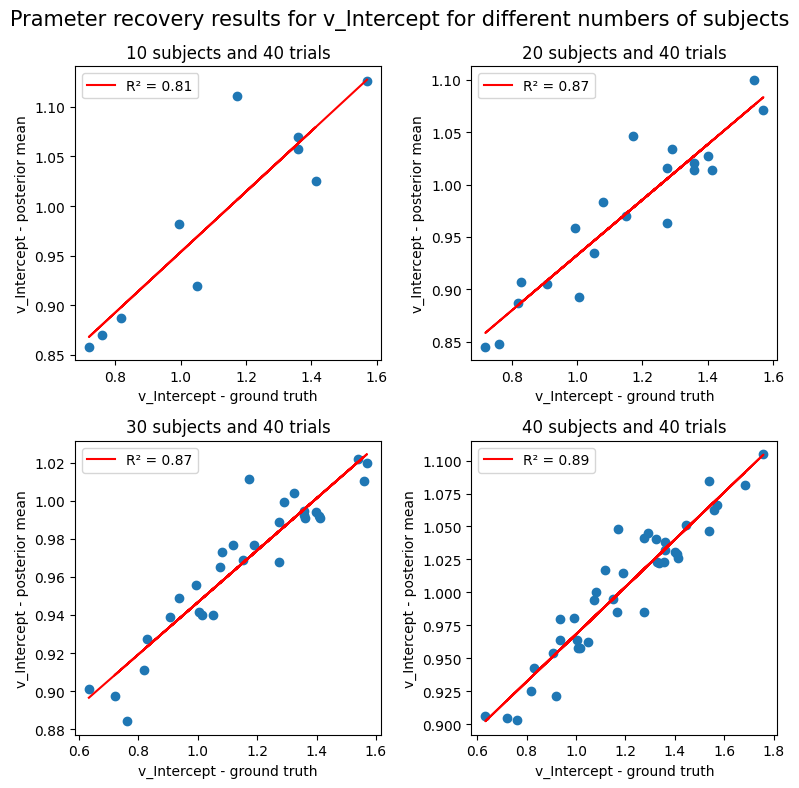

In [ ]:
fitted_list = post_fitted(sub='v_1|subject', grp='v_Intercept')
corre_plot(param='v_Intercept')

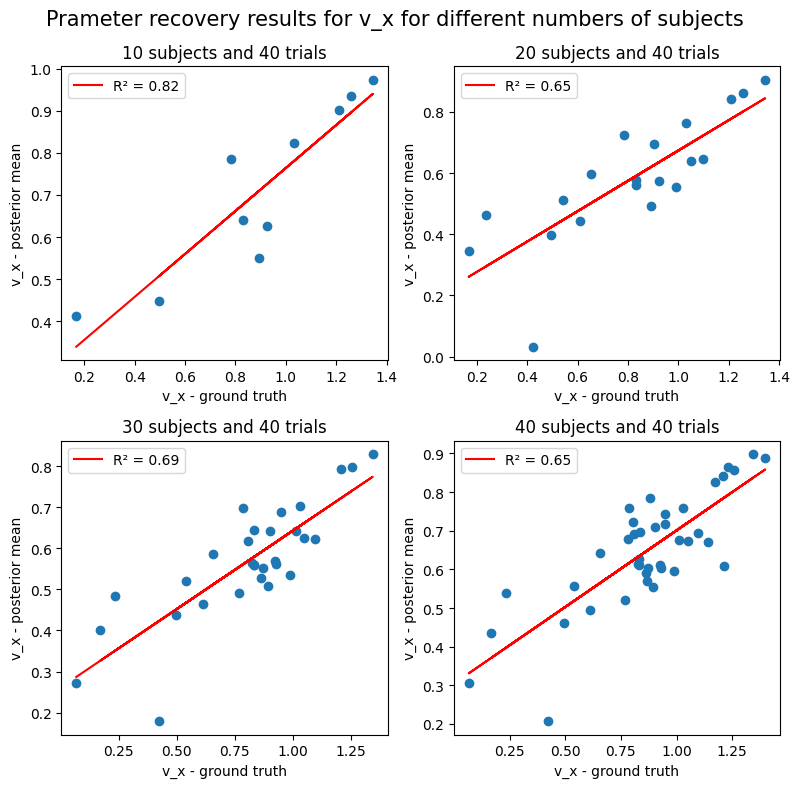

In [ ]:
fitted_list = post_fitted(sub='v_x|subject', grp='v_x')
corre_plot(param='v_x')

### Different numbers of trials

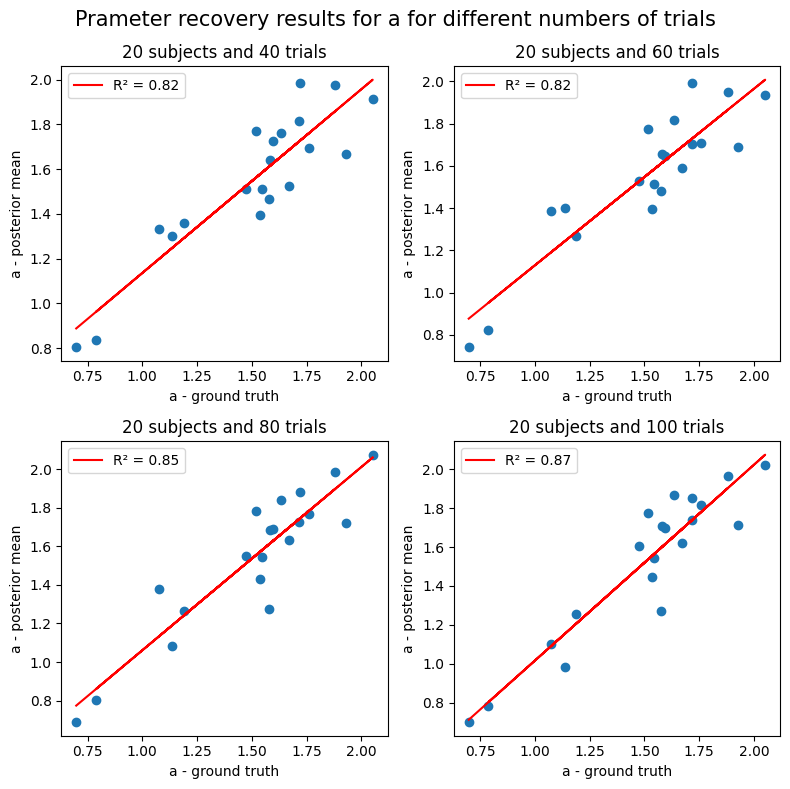

In [ ]:
fitted_list = post_fitted(sub='a_1|subject', grp='a_Intercept')
corre_plot(param='a')

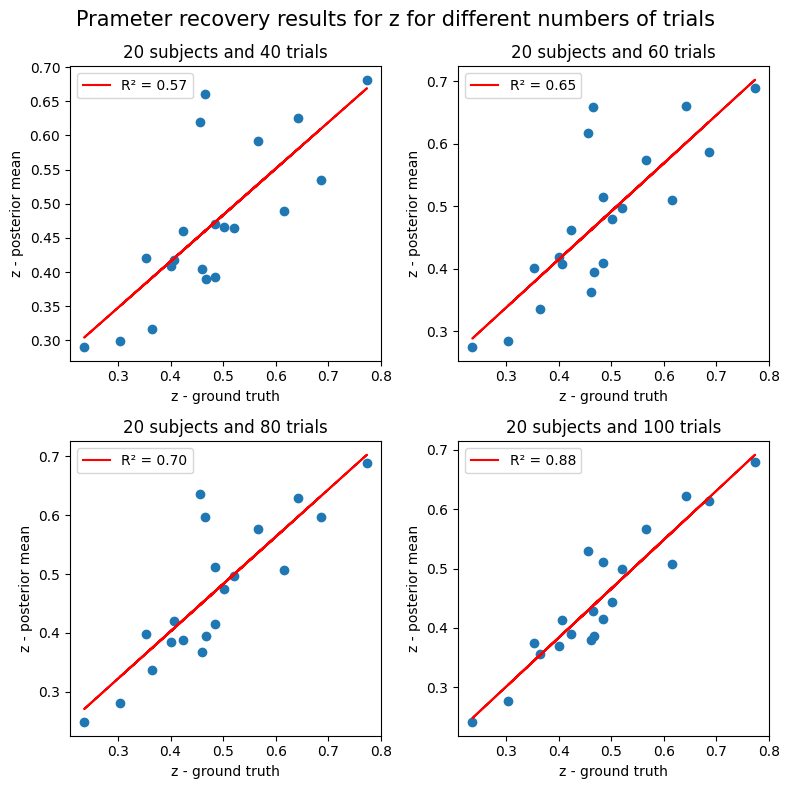

In [ ]:
fitted_list = post_fitted(sub='z_1|subject', grp='z_Intercept')
corre_plot(param='z')

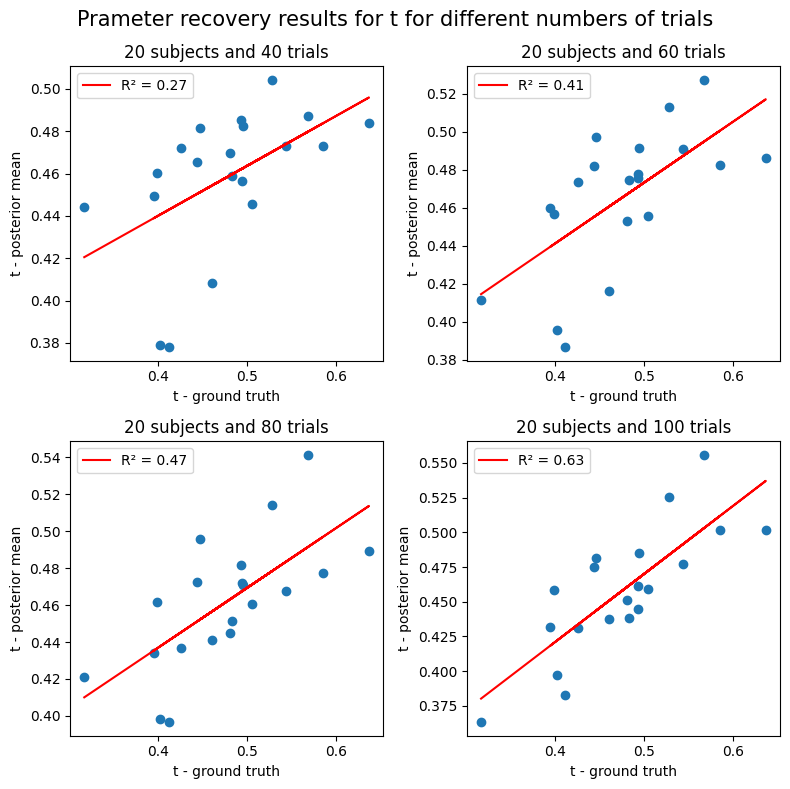

In [ ]:
fitted_list = post_fitted(sub='t_1|subject', grp='t_Intercept')
corre_plot(param='t')

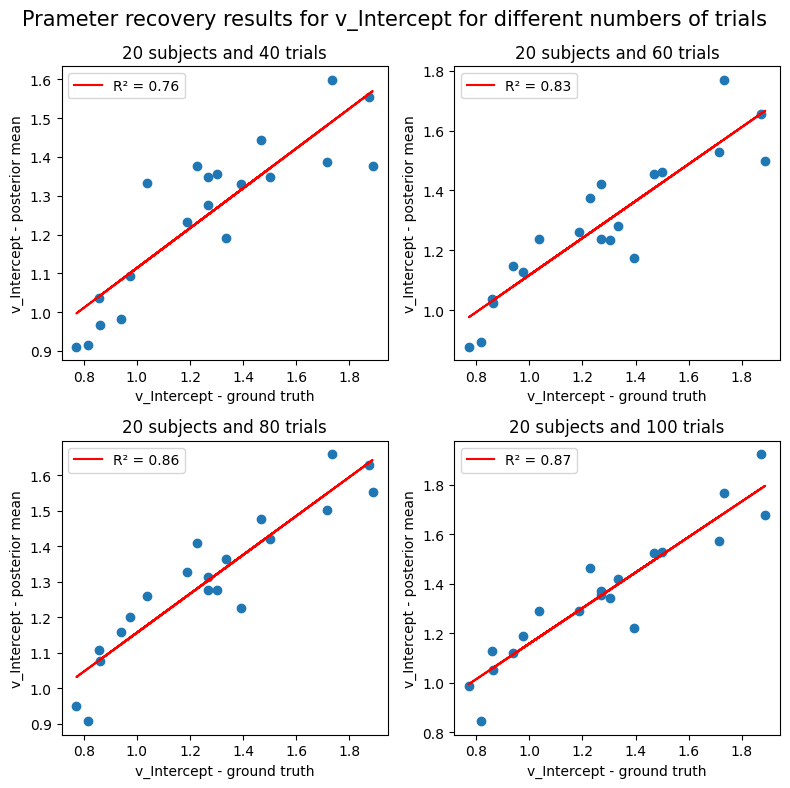

In [ ]:
fitted_list = post_fitted(sub='v_1|subject', grp='v_Intercept')
corre_plot(param='v_Intercept')

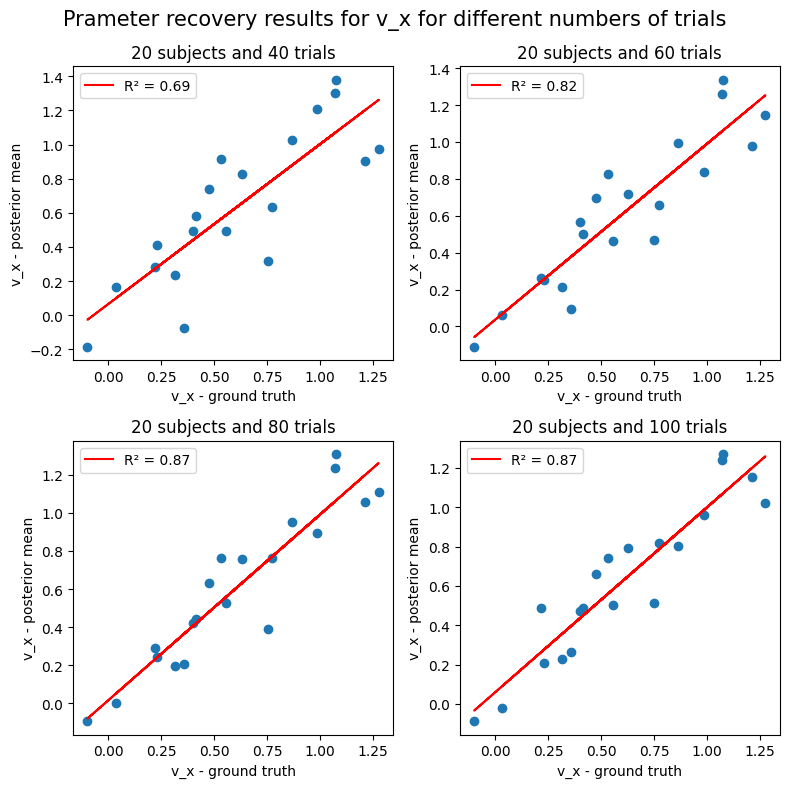

In [ ]:
fitted_list = post_fitted(sub='v_x|subject', grp='v_x')
corre_plot(param='v_x')

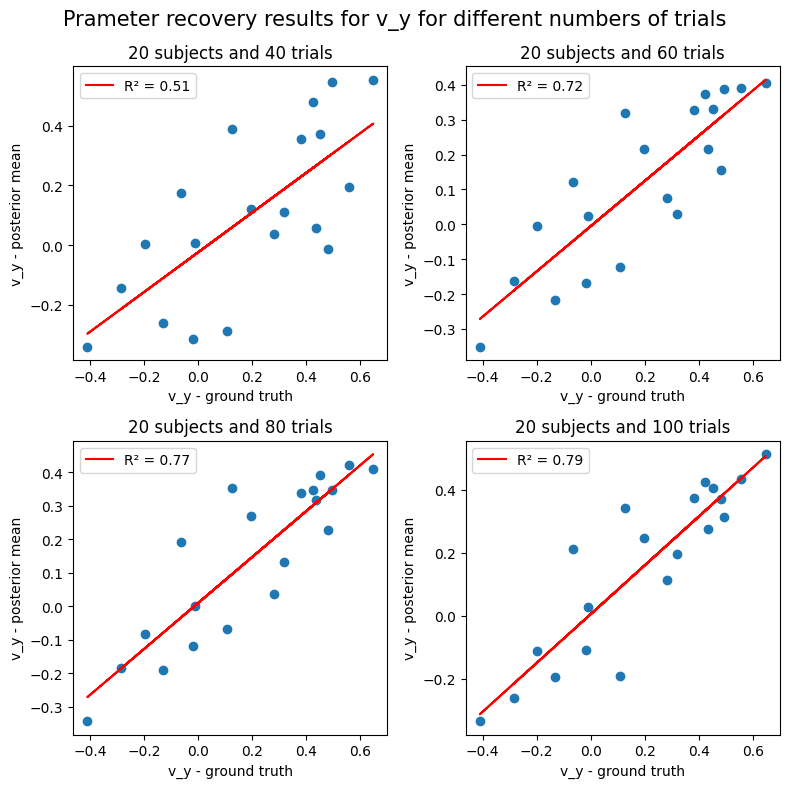

In [ ]:
fitted_list = post_fitted(sub='v_y|subject', grp='v_y')
corre_plot(param='v_y')

# Random (no use for now)

In [ ]:
# mean of ground truth
sum = 0
for i in range(40):
    sum += param_list[i]['a']
sum/40

0    1.603104
Name: a, dtype: float64

In [ ]:
# mean of posterior samples
np.mean(samples_model_reg_v_ddm_hier1A['posterior']['a'])

<xarray.DataArray 'a' ()>
array(1.60498066)

In [ ]:
# mean of posterior samples
sum = 0
for subject in range(n_subjects):
    for chain in range(shape[0]):
        for draw in range(shape[1]):
            sum += samples_model_reg_v_ddm_hier1A['posterior']["a"][chain, draw, subject * n_trials].values.item()
sum/(shape[0] * shape[1] * n_subjects)

1.604980659540188